In [64]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder


In [2]:
#Load original data which from cleaned_data folder on OSF
full_data = pd.read_csv('https://raw.githubusercontent.com/thimaipham/Data/main/morg-2014-emp.csv', 
                        dtype={16: str})

In [4]:
#Check data infomation
full_data.head(2)

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,ownchild,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94
0,3,2600310997690,January,AL,3151.6801,1692.0,40,43,1,NaN,...,0,0,"Native, Born In US",63,Employment services (5613),630,"Private, For Profit",No,No,Employed-At Work
1,5,75680310997590,January,AL,3457.1138,450.0,40,41,2,NaN,...,2,6,"Native, Born In US",63,Outpatient care centers (6214),5400,"Private, For Profit",No,No,Employed-Absent


In [5]:
# Filter the dataset for the occupation 
# "Lawyers, Judges, magistrates, and other judicial workers" (occupation code 2100)
occupation_code = 2100
data = full_data[full_data['occ2012'] == occupation_code]

# Count the number of observations for this occupation
data.shape[0]

1027

###### This filter data include 1027 observations

### Feture Engineering

##### EDA

In [38]:
# Checking for missing values
missing_values = data.isnull().sum()

# Examining data types
data_types = data.dtypes

# Display the results
print(missing_values, data_types) 



Unnamed: 0             0
hhid                   0
intmonth               0
stfips                 0
weight                 0
earnwke                0
uhours                 0
grade92                0
race                   0
ethnic               981
age                    0
sex                    0
marital                0
ownchild               0
chldpres               0
prcitshp               0
state                  0
ind02                  0
occ2012                0
class                  0
unionmme               0
unioncov              57
lfsr94                 0
earnings_per_hour      0
dtype: int64 Unnamed: 0             int64
hhid                   int64
intmonth              object
stfips                object
weight               float64
earnwke              float64
uhours                 int64
grade92                int64
race                   int64
ethnic               float64
age                    int64
sex                    int64
marital                int64
ownchild  

###### Missing values:
- `ethnic` and `unioncov` are 2 variables which contains many missing values. I will choose to drop some columns which I think might not be unnecessary (base on the missing values and domain knowledge). 

In [43]:
# Remove additional unnecessary columns
columns_to_remove = ['Unnamed: 0', 'ethnic', 'unioncov', 'intmonth', 'unionmme', 'lfsr94', 'state', 'ind02', 'occ2012']
data_cleaned = data.drop(columns_to_remove, axis=1)

# Checking for any remaining missing values
missing_values_cleaned = data_cleaned.isnull().sum()
print("Missing values in cleaned data:", missing_values_cleaned)

# Create a new variable 'earnings_per_hour'
data_cleaned['earnings_per_hour'] = data_cleaned['earnwke'] / data_cleaned['uhours']

# Display the first few rows of the data with the new variable
data_cleaned[['earnwke', 'uhours', 'earnings_per_hour']].head()


Missing values in cleaned data: hhid                 0
stfips               0
weight               0
earnwke              0
uhours               0
grade92              0
race                 0
age                  0
sex                  0
marital              0
ownchild             0
chldpres             0
prcitshp             0
class                0
earnings_per_hour    0
dtype: int64


,earnwke,uhours,earnings_per_hour
23,1442.30,50,28.84600
295,1384.61,40,34.61525
659,2307.00,50,46.14000
764,700.00,50,14.00000
901,2884.61,50,57.69220


#### Charts and distributions:

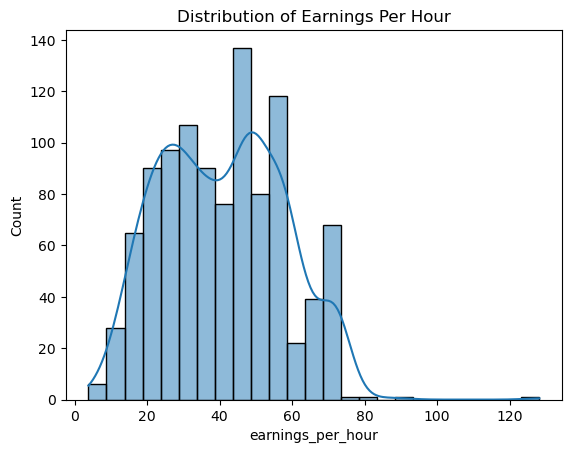

In [47]:
# Visualize the distribution of 'earnings_per_hour'
sns.histplot(data_cleaned['earnings_per_hour'], kde=True)
plt.title('Distribution of Earnings Per Hour')
plt.show()

##### It seems to have a few extreme values more than 100. I will drop the values. This might helps my models become more clear.

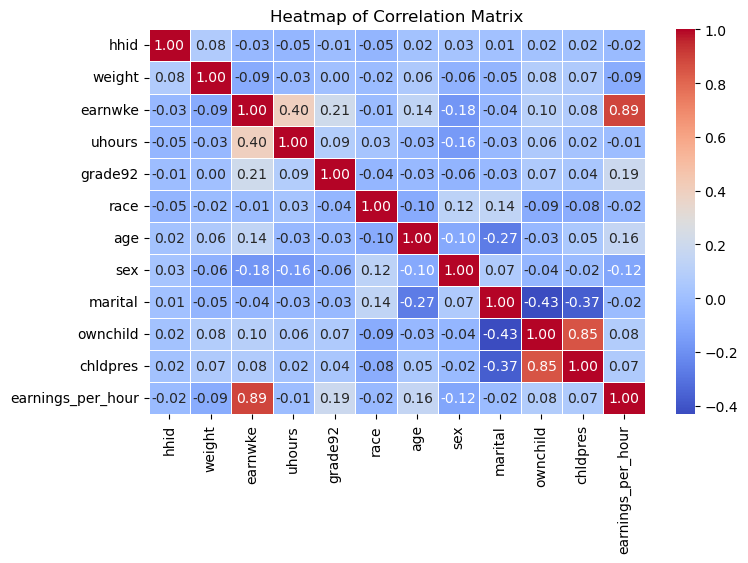

In [52]:
# Filter 'earnings_per_hour' < 100
data_filtered = data_cleaned[data_cleaned['earnings_per_hour'] < 100]

# Caculate correlation 
correlation_matrix = data_filtered.corr()

# Create heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()


##### From the heatmap, it does not show any clear correlationship between `earnings_per_hours` and other variables. `grade92`, `age`, `sex` might have a weak relationship with `earnings_per_hours` . But it does not tell much, so I will do some simple regression for the following steps

#### Dealing with categorical variables

In [69]:
# Choosing some categorical variables which I want to use
categorical_cols = ['race', 'sex', 'marital', 'grade92', 'class', 'prcitshp']

# Using One-Hot Encoding
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_data = encoder.fit_transform(data_filtered[categorical_cols])

# Create data frame from encoded data
encoded_columns = encoder.get_feature_names_out(categorical_cols)
data_encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns)

# Concat with data_cleaned
data_cleaned_encoded = data_filtered.drop(categorical_cols, axis=1).reset_index(drop=True)
data_cleaned_encoded = pd.concat([data_cleaned_encoded, data_encoded_df], axis=1)

# Target variable
y_encoded = data_cleaned_encoded['earnings_per_hour']


## Models 

In [113]:
# Classify predictors
# Grade92
grade92_specific_columns = ['grade92_38', 'grade92_39', 'grade92_40', 'grade92_41', 
                            'grade92_42', 'grade92_43', 'grade92_44', 'grade92_45', 'grade92_46']

#prcitshp - Citizenship status
prcitshp_specific_colums = ['prcitshp_Foreign Born, US Cit By Naturalization',
                            'prcitshp_Native, Born Abroad Of US Parent(s)',
                            'prcitshp_Native, Born In US',
                            'prcitshp_Native, Born in PR or US Outlying Area']
# class - class of worker
class_specific_columns = [ 'class_Government - Local', 'class_Government - State',
                          'class_Private, For Profit', 'class_Private, Nonprofit']

#race
race_specific_columns = ['race_2', 'race_3', 'race_4', 'race_5',
                         'race_6', 'race_7', 'race_8', 'race_10', 'race_11']
# marital - marriage status
marital_specific_columns = [ 'marital_2', 'marital_3', 'marital_4', 'marital_5', 'marital_6', 'marital_7']


In [91]:
data_cleaned_encoded.columns

Index(['hhid', 'stfips', 'weight', 'earnwke', 'uhours', 'age', 'ownchild',
       'chldpres', 'earnings_per_hour', 'race_2', 'race_3', 'race_4', 'race_5',
       'race_6', 'race_7', 'race_8', 'race_10', 'race_11', 'sex_2',
       'marital_2', 'marital_3', 'marital_4', 'marital_5', 'marital_6',
       'marital_7', 'grade92_38', 'grade92_39', 'grade92_40', 'grade92_41',
       'grade92_42', 'grade92_43', 'grade92_44', 'grade92_45', 'grade92_46',
       'class_Government - Local', 'class_Government - State',
       'class_Private, For Profit', 'class_Private, Nonprofit',
       'prcitshp_Foreign Born, US Cit By Naturalization',
       'prcitshp_Native, Born Abroad Of US Parent(s)',
       'prcitshp_Native, Born In US',
       'prcitshp_Native, Born in PR or US Outlying Area'],
      dtype='object')

### Building Model 1 using `age` as the predictor

In [109]:
# Building Model 1 using 'age' as the predictor
X1 = sm.add_constant(data_cleaned_encoded[['age']])
model_1 = sm.OLS(y_encoded, X1).fit()

# Evaluating Model 1
predicted_earnings_1 = model_1.predict(X1)
rmse_1 = np.sqrt(mean_squared_error(y_encoded, predicted_earnings_1))
bic_1 = model_1.bic

# Print the results
print("RMSE of Model 1:", rmse_1)
print("BIC of Model 1:", bic_1)

RMSE of Model 1: 16.534031295209193
BIC of Model 1: 8682.252114902585


### Building model 2  using `age` + `grade92`  as the predictor

In [110]:
# Building Model 2 using 'age' and specific 'grade92' categories as predictors
predictors_model_2 = ['age'] + grade92_specific_columns

# Adding a constant to the model
X2 = sm.add_constant(data_cleaned_encoded[predictors_model_2])

# Fitting the OLS model
model_2 = sm.OLS(y_encoded, X2).fit()

# Evaluating Model 2
# Predicting earnings and calculating RMSE
predicted_earnings_2 = model_2.predict(X2)
rmse_2 = np.sqrt(mean_squared_error(y_encoded, predicted_earnings_2))

# Calculating BIC for Model 2
bic_2 = model_2.bic

# Printing the results
print("RMSE of Model 1:", rmse_2)
print("BIC of Model 1:", bic_2)



RMSE of Model 1: 15.9518208303379
BIC of Model 1: 8671.093281163849


### Building model 3

In [123]:
# Building Model 3 using 'age' and specific 'grade92' categories as predictors
predictors_model_3 = ['age', 'sex_2'] + grade92_specific_columns + prcitshp_specific_colums + class_specific_columns + race_specific_columns

# Adding a constant to the model
X3 = sm.add_constant(data_cleaned_encoded[predictors_model_3])

# Fitting the OLS model
model_3 = sm.OLS(y_encoded, X3).fit()

# Evaluating Model 3
# Predicting earnings and calculating RMSE
predicted_earnings_3 = model_3.predict(X3)
rmse_3 = np.sqrt(mean_squared_error(y_encoded, predicted_earnings_3))

# Calculating BIC for Model 3
bic_3 = model_3.bic

# Printing the results
print("RMSE of Model 1:", rmse_3)
print("BIC of Model 1:", bic_3)



RMSE of Model 1: 15.464851892045948
BIC of Model 1: 8732.276427223833


### Building model 4

In [126]:
# Define predictor model 4
predictors_model_4 = ['age', 'sex_2', 'ownchild'] + grade92_specific_columns + prcitshp_specific_colums + class_specific_columns + race_specific_columns +marital_specific_columns

# Adding a constant to the model
X4 = sm.add_constant(data_cleaned_encoded[predictors_model_4])

# Fitting the OLS model
model_4 = sm.OLS(y_encoded, X4).fit()

# Evaluating Model 3
# Predicting earnings and calculating RMSE
predicted_earnings_4 = model_4.predict(X4)
rmse_4 = np.sqrt(mean_squared_error(y_encoded, predicted_earnings_4))

# Calculating BIC for Model 3
bic_4 = model_4.bic

# Printing the results
print("RMSE of Model 4:", rmse_4)
print("BIC of Model 4:", bic_4)


RMSE of Model 4: 15.331050800301616
BIC of Model 4: 8762.979343109015
